In [ ]:
pip install matplotlib ipywidgets ipympl smoothfit

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import convolve2d

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge effects.
    Useful for exponential bleaching curves.

    Parameters:
    D (numpy.ndarray): Input data array where the first dimension is time.
    mode (str): Smoothing mode, either 'movmedian' or 'movmean'.
    window (int): Window size for smoothing.

    Returns:
    numpy.ndarray: Smoothed data array.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = min(window, D.shape[0])
    t = np.arange(1, window + 1)
    p = np.vstack([t, np.ones_like(t)]).T

    if mode == 'movmedian':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        sVals = pd.DataFrame(D).rolling(window=window, min_periods=1, center=True).mean().values
    else:
        raise ValueError("Mode must be either 'movmedian' or 'movmean'")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t - 1, ix]))[0]
        if len(inds) > 0:
            slope, intercept, _, _, _ = linregress(inds + 1, D[inds, ix])
            lVals[:, ix] = p @ np.array([slope, intercept])

    weights = t / len(t)
    sVals[t - 1, :] = weights[:, np.newaxis] * sVals[t - 1, :] + (1 - weights[:, np.newaxis]) * lVals

    if mode == 'movmedian':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).median().values
    elif mode == 'movmean':
        mVals = pd.DataFrame(D[:min(len(D), 2 * window), :] - sVals[:min(len(D), 2 * window), :]).rolling(window=window, min_periods=1, center=True).mean().values

    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)

    return sVals

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

%matplotlib ipympl

def play_movie(mov, fr=30, gain=1, magnification=1, offset=0):
    """
    Play a movie using matplotlib and ipywidgets.
    
    Parameters:
    ----------
    mov : 3D numpy.ndarray
        Movie, time x height x width
    fr : float, optional
        Frame rate, default is 30
    gain : float, optional
        Multiplier for contrast, default is 1
    magnification : float, optional
        Magnification factor, default is 1
    offset : float, optional
        Offset for contrast, default is 0
        
    Returns:
    -------
    None
    """
    # Ensure mov is a 3D array
    if mov.ndim != 3:
        raise ValueError("Input array mov must be a 3D array")
    
    # Calculate the global min and max for normalization
    minmov = np.nanmin(mov)
    maxmov = np.nanmax(mov)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8*magnification, 6*magnification))
    plt.subplots_adjust(bottom=0.25)
    
    # Display the first frame
    img_display = ax.imshow(mov[:, :, 0], cmap='gray', vmin=minmov, vmax=maxmov)
    ax.axis('off')
    
    def update(frame):
        img = mov[:, :, frame]
        # img = (img - minmov) / (maxmov - minmov)  # Normalize to 0-1
        # img = gain * img + offset  # Apply gain and offset
        # img = np.clip(img, 0, 1)  # Clip to 0-1 range
        
        img_display.set_data(img)
        ax.set_title(f'Frame {frame}')
        fig.canvas.draw_idle()
    
    slider = widgets.IntSlider(min=0, max=mov.shape[2]-1, step=1, description='Frame')
    play_widget = widgets.Play(
        value=0,
        min=0,
        max=mov.shape[2]-1,
        step=1,
        interval=1000/fr,
        description="Press play",
        disabled=False
    )
    
    widgets.jslink((play_widget, 'value'), (slider, 'value'))
    
    ui = widgets.HBox([play_widget, slider])
    display(ui)
    
    def on_slider_change(change):
        update(change['new'])
    
    slider.observe(on_slider_change, names='value')
    
    # Initialize the display
    update(0)


In [3]:
from scipy.io import loadmat
import tempfile
import glob
import re
import cv2
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation

from scipy.ndimage import median_filter

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tenacity import retry, stop_after_attempt, wait_fixed
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Define the retry decorator
@retry(stop=stop_after_attempt(4), wait=wait_fixed(3))
def read_tiff_file(fn):
    print('Reading:', fn)
    A = ScanImageTiffReader(fn)
    Ad = np.array(A.data(), dtype=np.float64).T
    return Ad

In [5]:
import numpy as np
import time
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt
from skimage.morphology import square
import numpy as np
from scipy.linalg import svd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.sparse.linalg import svds
from scipy.ndimage import convolve, shift
from scipy.stats import scoreatpercentile
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.io import savemat, loadmat
import pdb


def smoothdata(data, dim, method, window_size, nanflag):
    if method != 'movmedian':
        raise ValueError("Currently only 'movmedian' method is supported.")
    if nanflag not in ['omitnan', 'includenan']:
        raise ValueError("nanflag must be 'omitnan' or 'includenan'.")

    if dim != 3:
        raise ValueError("Currently only smoothing along the 3rd dimension is supported.")
    
    # Assuming data is a 3D numpy array
    smoothed_data = np.copy(data)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if nanflag == 'omitnan':
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True, min_periods=1).median()
            else:
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True).median()
    
    return smoothed_data

def localize_flashes_bergamo(IM, aData, params, GT, doPlot=False):
    # Inputs:
    # IM:        3D recording, X x Y x Time
    # aData:     alignment metadata
    
    tau = params['tau_s'] / (params['frametime'] * params['dsFac'])  # time constant in frames
    print(f"tau (time constant in frames): {tau}")
    params['tau_frames'] = tau

    sigma = params['sigma_px']  # space constant in pixels
    print(f"sigma (space constant in pixels): {sigma}")

    denoiseWindow = params['denoiseWindow_samps']
    print(f"denoiseWindow: {denoiseWindow}")

    baselineWindow = int(np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac'])))
    print(f"baselineWindow: {baselineWindow}")
    
    nans = np.isnan(IM)

    print(f"# Nans:", np.sum(nans))
    
    # Compute the mean image, ignoring NaNs
    IMavg = np.nanmean(IM, axis=2)
    
    # Compute the gamma-corrected image
    IMgamma = np.sqrt(np.maximum(0, IMavg))
    
    # Compute the 10th percentile of the mean image, ignoring NaNs
    BG = np.nanpercentile(IMavg, 10)
    
    print(f"BG:", BG)

    IM = np.array(IM, dtype=np.float64)
    BG = np.array(BG, dtype=np.float64)
    
    # Subtract background
    IMf = IM - BG

    # Set NaN values to 0
    IMf[nans] = 0

    # filter_size = int(2 * np.ceil(10 * sigma)) + 1
    
    # # Create a 2D array with zeros
    # DoGfilt = np.zeros((filter_size, filter_size))
    
    # # Set the center element to 1
    # DoGfilt[int(np.ceil(filter_size / 2)), int(np.ceil(filter_size / 2))] = 1
    
    # # Apply Gaussian filters
    # DoGfilt1 = cv2.GaussianBlur(DoGfilt, (0, 0), sigma, sigma)
    # DoGfilt2 = cv2.GaussianBlur(DoGfilt, (0, 0), 5 * sigma, 5 * sigma)
    
    # # Subtract the two filtered images
    # DoGfilt = DoGfilt1 - DoGfilt2
    
    # # Subtract the mean value
    # DoGfilt = DoGfilt - np.mean(DoGfilt)
    DoGfilt = loadmat('/root/capsule/scratch/DoGfilt.mat')['DoGfilt']  #hardcoded results from matlab

    # Apply spatial filter
    # IMf = ndimage.convolve(IMf, np.ones((1, 1, 1)), mode='constant', cval=0.0)
    # # plt.figure()
    # # plt.imshow(IMf[:,:,1])
    # # plt.show()
    # IMstruct = cv2.filter2D(np.maximum(0, IMavg), -1, np.ones((1, 1)), borderType=cv2.BORDER_CONSTANT)
    # if IMf.ndim == 3:
    #     IMf_filtered = np.zeros_like(IMf, dtype=np.float64)
    #     for i in range(IMf.shape[2]):
    #         IMf_filtered[:,:,i] = cv2.filter2D(IMf[:,:,i].astype(np.float64), -1, DoGfilt.astype(np.float64))
    #     IMf = IMf_filtered
    # else:
    #     IMf = cv2.filter2D(IMf.astype(np.float64), -1, DoGfilt.astype(np.float64))

    if IMf.ndim == 3:
        IMf_filtered = np.zeros_like(IMf)
        for i in range(IMf.shape[2]):
            IMf_filtered[:, :, i] = convolve2d(IMf[:, :, i], DoGfilt, mode='same')
        IMf = IMf_filtered
    else:
        IMf = convolve2d(IMf, DoGfilt, mode='same')

    IMstruct = convolve2d(np.maximum(0, IMavg), DoGfilt, mode='same')

    # Highpass filter in time
    IMf[nans] = np.nan
    
    # # Convert the 3D array to a 2D DataFrame for smoothing
    # df = pd.DataFrame(IMf.reshape(-1, IMf.shape[2]))
    
    # # Apply moving median smoothing along the third dimension
    # smoothed = df.apply(lambda x: x.rolling(window=baselineWindow, center=True, min_periods=1).median(), axis=1)
    

    print('IMf before smoothdata substraction----->', IMf)
    
    # Subtract the smoothed data from the original data
    IMf = IMf - smoothdata(IMf, 3, 'movmedian', baselineWindow, 'omitnan')
    
    # # Reassign NaN values
    # # IMf[nans] = np.nan

    nans = np.isnan(IMf)
    
    # # plt.imshow(np.mean(IMf, axis = 2), cmap='jet')
    # # plt.show()

    # Remove motion-associated variance
    IMf = decorrelate_motion(IMf, IMstruct, aData, params)

    return IMf

    # # plt.figure()
    # # plt.imshow(IMf[:,:,1])
    # # plt.show()
    
    # # Normalize by expected poisson noise
    # IMavg_nans = np.isnan(IMavg)
    # print("IMavg_nans", IMavg_nans)

    # Pnoise = np.maximum(IMavg, 0)  # squared poisson noise
    # Mnoise = np.sqrt(
    #     cv2.filter2D(np.roll(Pnoise, 1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
    #     cv2.filter2D(np.roll(Pnoise, -1, axis=0) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
    #     cv2.filter2D(np.roll(Pnoise, 1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2 +
    #     cv2.filter2D(np.roll(Pnoise, -1, axis=1) - Pnoise, -1, DoGfilt, borderType=cv2.BORDER_CONSTANT)**2
    # )


    # IMnoise = np.sqrt(cv2.filter2D(Pnoise, -1, np.abs(DoGfilt), borderType=cv2.BORDER_CONSTANT))  # total signal contributing to each measurement
    # IMnoise = IMnoise + scoreatpercentile(IMnoise[~IMavg_nans], 33) + 0.2 * np.sqrt(Mnoise)  # add a noise floor to the dimmer pixels
    # IMnoise[IMavg_nans] = np.nan
    
    # # Add an extra dimension to IMnoise to match the shape of IMf
    # IMnoise = IMnoise[:, :, np.newaxis]

    # IMf = IMf / IMnoise

    # # # Add an extra dimension to IMnoise to match the shape of IMf
    # # IMnoise = IMnoise[:, :, np.newaxis]

    # # IMf = IMf / IMnoise

    # # Temporal matched filter
    # IMf[nans] = 0
    # mem = IMf[:, :, -1]
    # gamma = np.exp(-1 / tau)
    # for t in range(IMf.shape[2] - 1, -1, -1):
    #     IMf[:, :, t] = np.maximum(0, gamma * mem) + (1 - gamma) * IMf[:, :, t]
    #     mem = IMf[:, :, t]
    # IMf[nans] = np.nan

    # # Compute a summary image based on skewness
    # summary = np.nanmean(IMf**3, axis=2)

    # # Create a kernel
    # kernel = np.ones((5,5),np.uint8)

    # # Perform dilation on the mask of NaN values
    # dilated_mask = cv2.dilate(np.isnan(summary).astype(np.uint8), kernel, iterations = 1)

    # # Set the dilated areas to NaN
    # summary[dilated_mask == 1] = np.nan

    # P = get_tiled_peaks(IMf, IMavg, summary)

    # # Plot a figure
    # if doPlot:
    #     plot_summary(summary, IMgamma, P, GT)

    # return summary, P, params

def plot_summary(summary, IMgamma, P, GT):
    red = summary / np.nanpercentile(summary, 99)
    cyan = IMgamma / np.nanpercentile(IMgamma, 99)
    rgb = np.dstack((red, cyan, cyan))

    rgb_normalized = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))

    plt.figure()
    # plt.imshow(rgb_normalized)
    plt.imshow( np.dstack((red, cyan, cyan)))

    C_GT = GT[0]
    R_GT = GT[1]
    plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
    plt.scatter(R_GT, C_GT, marker='x', c='yellow', s=100)
    plt.show()

def get_tiled_peaks(IM, IMavg, summary):
    nan_mask = np.isnan(IM).astype(np.uint8)

    # Create a 5x5 kernel of ones
    kernel = np.ones((5, 5), np.uint8)

    dilated = np.empty_like(nan_mask)
    for i in range(nan_mask.shape[2]):
        dilated[:, :, i] = cv2.dilate(nan_mask[:, :, i], kernel)

    # Invert the result to get the valid mask
    valid = ~dilated.astype(bool)
    peaks = valid
    
    for dim in range(3):
        peaks = peaks & (IM > np.roll(IM, 1, axis=dim)) & (IM > np.roll(IM, -1, axis=dim))
        
    # linInds = np.where(peaks)
    # vvv = IM[linInds]
    # rrr, ccc, ttt = linInds

    linInds = np.where(peaks.flatten())[0]
    vvv = IM.flatten()[linInds]
    rrr, ccc, ttt = np.unravel_index(linInds, peaks.shape)

    print("rrr, ccc, ttt, peaks.shape, linInds:", len(rrr), len(ccc), len(ttt), peaks.shape, len(linInds))

    sz = IM.shape
    tilesize = 64
    tilestartsR = np.arange(1, sz[0] - tilesize // 4, tilesize // 2)
    tileendsR = np.minimum(sz[0], tilestartsR + tilesize - 1)
    tilestartsC = np.arange(1, sz[1] - tilesize // 4, tilesize // 2)
    tileendsC = np.minimum(sz[1], tilestartsC + tilesize - 1)

    summaryVals = summary[rrr, ccc]

    keep = np.zeros(len(ttt), dtype=bool)  # which events to keep
    vNorm = np.zeros(len(ttt))  # the event sizes, Z-scored

    for rix in range(len(tilestartsR)):
        for cix in range(len(tilestartsC)):
            selStats = (rrr >= tilestartsR[max(0, rix-1)]) & (rrr <= tileendsR[min(len(tileendsR)-1, rix+1)]) & \
                    (ccc >= tilestartsC[max(0, cix-1)]) & (ccc <= tileendsC[min(len(tileendsC)-1, cix+1)])

            S = summary[tilestartsR[max(0, rix-1)]:tileendsR[min(len(tileendsR)-1, rix+1)]+1, 
                        tilestartsC[max(0, cix-1)]:tileendsC[min(len(tileendsC)-1, cix+1)]+1]
            Sp = np.percentile(S.flatten(), [1, 33])
            Sthresh = Sp[1] + 5 * (Sp[1] - Sp[0])
            selS = summaryVals > Sthresh

            vals = vvv[selStats & selS]
            ptile = np.percentile(vals, [1, 50])
            vals = 3 * (vals - ptile[1]) / (ptile[1] - ptile[0])
            thresh = ptile[1] + 5 * (ptile[1] - ptile[0])  # threshold is 2*[98% confint], corresponding to an SNR of ~6
            selTile = (rrr >= tilestartsR[rix]) & (rrr <= tileendsR[rix]) & \
                    (ccc >= tilestartsC[cix]) & (ccc <= tileendsC[cix]) & (vvv > thresh) & selS
            keep[selTile] = True
            vNorm[selStats & selS] = np.maximum(vNorm[selStats & selS], vals)


    rrr = rrr[keep]
    ccc = ccc[keep]
    ttt = ttt[keep]
    vvv = vNorm[keep]

    # Upsample for superresolution
    pR = []
    pC = []

    for peakIx in range(len(ttt)-1, -1, -1):
        R = IM[rrr[peakIx]+np.arange(-1,2), ccc[peakIx], ttt[peakIx]]
        C = IM[rrr[peakIx], ccc[peakIx]+np.arange(-1,2), ttt[peakIx]]

        ratioR = min(1e6, (R[1] - R[0]) / (R[1] - R[2]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        pR.append(rrr[peakIx] - dR)

        ratioC = min(1e6, (C[1] - C[0]) / (C[1] - C[2]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        pC.append(ccc[peakIx] - dC)

    print("pR.shape:", len(pR))
    P = {'row': pR, 'col': pC, 't': ttt, 'val': vvv}
    return P
    
def decorrelate_motion(IM, IMavg, aData, window):

    print("IM---->", IM)
    print("IMavg---->", IMavg)
    print("aData---->", aData)
    print("window---->", window)

    nanFrames = np.all(np.isnan(IM), axis=(0, 1))
    
    # Replace NaNs with zeros
    IMnan = np.isnan(IM)
    goodPixels = np.mean(~IMnan, axis=2) > 0.9
    IM2 = IM.copy()
    IM2[IMnan] = 0

    # Select non-NaN frames
    IM2 = IM2[:, :, ~nanFrames]

    # Reshape
    sz = IM2.shape
    IM2 = IM2.reshape(sz[0] * sz[1], sz[2], order='F')

    # Subtract mean
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)
    def imtranslate(image, shift_val):
        return shift(image, shift_val, mode='nearest')
    
    imageGrads = np.stack([
        IMavg - imtranslate(IMavg, [1, 0]),
        IMavg - imtranslate(IMavg, [0, 1]),
        IMavg - imtranslate(IMavg, [-1, 0]),
        IMavg - imtranslate(IMavg, [0, -1])
    ], axis=2)
    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1)
    nPCs = 20
    U, S, Vt = svds(IM2[goodPixels.ravel(), :], k=nPCs)
    b = np.linalg.lstsq(imageGrads[goodPixels.ravel(), :], U, rcond=None)[0]
    correction = (imageGrads @ b) @ np.diag(S) @ Vt
    IM[:, :, ~nanFrames] -= correction.reshape(sz[0], sz[1], -1)
    return IM

In [6]:
import os
import glob
import pandas as pd
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/'

GT_fns = "/root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/"
h5_files = sorted(glob.glob(GT_fns + "*.h5"))

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*_DOWNSAMPLED-2x.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+_DOWNSAMPLED-2x.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 3,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = [
    os.path.join(
        os.path.dirname(path),
        re.sub(r'Trial\d+_DOWNSAMPLED-2x.tif$', f'Trial{trial_num}_ALIGNMENTDATA.h5', os.path.basename(path))
    )
    for trial_num, path in enumerate(strict_matching_files, start=1)
]

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
peaks = [None] * len(strict_matching_files)

# Read the first file to get the shape
first_fn = strict_matching_files[0]
first_IM = read_tiff_file(first_fn)

# Initialize meanIM
meanIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
actIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
strict_matching_files = sorted(strict_matching_files, key=lambda x: int(re.search(r'Trial(\d+)', x).group(1)))

for trialIx in range(len(strict_matching_files)-1, -1, -1):
    if trialIx == 7:
        break
    
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]
    fn_GT = h5_files[trialIx]

    # Load the TIFF
    IM = read_tiff_file(fn)

    # savemat('/root/capsule/scratch/IM.mat', {'zzz': IM})
    
    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    # Set the specified elements of 'meanIM' to NaN
    meanIM[-1:IM.shape[0], :, :, :] = np.nan
    meanIM[:, -1:IM.shape[1], :, :] = np.nan
    meanIM[:, :, :, trialIx] = np.nan
    meanIM[0:IM.shape[0], 0:IM.shape[1], :, trialIx] = np.nanmean(IM, axis=3)

    # Create a temporary file for the HDF5 operations
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
        temp_file_path = temp_file.name

    # Copy contents from the original HDF5 file to the temporary file
    with h5py.File(original_gt_path[trialIx], 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
        print(f"Reading:", original_gt_path[trialIx])
        for key in original_gt.keys():
            original_gt.copy(key, temp_gt)

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        with h5py.File(fn_GT, "r") as f:
            print(f"Reading:", fn_GT)
            # Get the group 'GT'
            GT = f['GT']
            C_GT = np.array(GT['C'])
            R_GT = np.array(GT['R'])

            GT = [C_GT, R_GT]
            
        # Check if the dataset 'aData/dsFac' exists, create it if not
        if 'aData/dsFac' in temp_gt:
            dsFac_dset = temp_gt['aData/dsFac']
        else:
            dsFac_dset = temp_gt.create_dataset('aData/dsFac', data=round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()])))

        params['dsFac'] = dsFac_dset[()]
        print("params['dsFac']:", params['dsFac'])
        
        params['frametime'] = temp_gt['aData/frametime'][()]
        numChannels = temp_gt['aData/numChannels'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Flatten the array
        rank_corr_flat = temp_gt['aData/aRankCorr'][()].flatten()

        # Apply the smoothExp function with 'movmedian'
        tmp = rank_corr_flat - smooth_exp(rank_corr_flat, 'movmedian', int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()]))))

        # Apply the smoothExp function with 'movmean'
        filtTmp = smooth_exp(tmp, 'movmean', int(np.ceil(0.2 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))) 

    #     # plt.plot(filtTmp)
    #     # plt.show()
        # Create a binary mask where filtTmp is less than -4 times the standard deviation
        threshold = -4 * np.std(filtTmp)
        binary_mask = filtTmp < threshold

        # Dilate the binary mask
        kernel = np.ones((1, 5), np.uint8)
        discardFrames[trialIx] = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

        # Convert discardFrames to a boolean array
        discardFrames_bool = discardFrames[trialIx].astype(bool)

        # Process the raw images
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])

        # Set the frames to NaN where discardFrames_bool is True
        rawIMs[trialIx][:,:,discardFrames_bool.ravel()] = np.nan

        if numChannels == 2:
            rawIM2s[trialIx] = np.squeeze(IM[:,:,1,:])
            rawIM2s[trialIx][:,:,discardFrames[trialIx]] = np.nan
            
        IMf= localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, GT, True)
        # IMc, peaks[trialIx], params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, GT, True)
    #     actIM[-1:IMc.shape[0], :, :, :] = np.nan
    #     actIM[:, -1:IMc.shape[1], :, :] = np.nan
    #     actIM[:, :, :, trialIx] = np.nan
    #     actIM[0:IMc.shape[0], 0:IMc.shape[1], 0, trialIx] = IMc

    # # Clean up the temporary file
    # os.remove(temp_file_path)


Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial4_DOWNSAMPLED-2x.tif
Trial: 8
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial9_DOWNSAMPLED-2x.tif
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-ReleaseSites/13/SIMULATION_scan_00001_13_Trial9_ALIGNMENTDATA.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-ReleaseSites_1/13/SIMULATION_scan_00001_13_Trial9_groundtruth.h5
params['dsFac']: 2
tau (time constant in frames): 5.869565217391305
sigma (space constant in pixels): 1.33
denoiseWindow: 35
baselineWindow: 435
# Nans: 837100
BG: 8665.818995877686
IMf before smoothdata substraction-----> [[[ 8.12238259e+02  2.16767562e+03  1.50455961e+03 ... -5.11349367e+02
   -4.20775417e+02 -7.51882802e+02]
  [ 1.41294813e+03  2.46412785e+03  1.70378072e+03 ... -1.12905398e+03
   -9.77985356e+02 -9.11346670e+02]
  [ 1.50214336e+03  1.42722686e+03  1.041

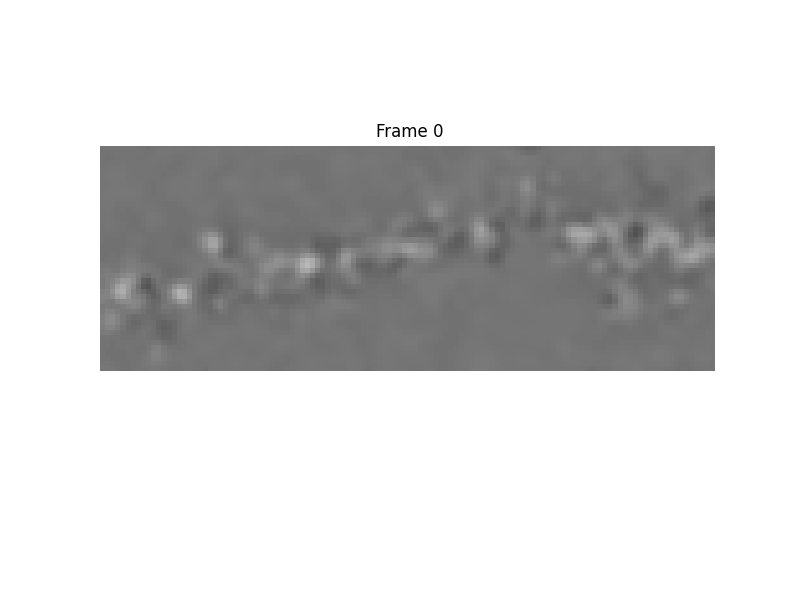

In [7]:
play_movie(IMf, fr=30)

In [7]:
IMf[:,:,0]

array([[ -688.36038502,  -751.85298819,  -712.32731202, ...,
         1882.42781228,   486.64429416,            nan],
       [-1270.77995348, -1686.52227924, -1719.5137747 , ...,
         1211.8704089 ,  -325.55336331,            nan],
       [-1587.46150864, -2071.19853288, -2091.48549652, ...,
          357.72688261, -1228.76664565,            nan],
       ...,
       [ 1060.12577999,  1195.50756502,   -34.90371431, ...,
         1471.38242576,   464.34216609,            nan],
       [ 1727.40529822,  2492.30620041,  1489.93311987, ...,
           79.21928117,  -186.86159951,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [14]:
from scipy.signal import medfilt

baseline_window = 435

from scipy.signal import savgol_filter

def smooth_data_savgol(IMf, window_length, polyorder, axis=2):
    # Apply Savitzky-Golay filter
    smoothed_data = savgol_filter(IMf, window_length=window_length, polyorder=polyorder, axis=axis, mode='nearest')
    return smoothed_data

yhat = smooth_data_savgol(IMf, baseline_window, 0)

In [19]:
import numpy as np
import pandas as pd

def smoothdata(data, dim, method, window_size, nanflag):
    if method != 'movmedian':
        raise ValueError("Currently only 'movmedian' method is supported.")
    if nanflag not in ['omitnan', 'includenan']:
        raise ValueError("nanflag must be 'omitnan' or 'includenan'.")

    if dim != 3:
        raise ValueError("Currently only smoothing along the 3rd dimension is supported.")
    
    # Assuming data is a 3D numpy array
    smoothed_data = np.copy(data)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if nanflag == 'omitnan':
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True, min_periods=1).median()
            else:
                smoothed_data[i, j, :] = pd.Series(data[i, j, :]).rolling(window=window_size, center=True).median()
    
    return smoothed_data

# Example usage:
# IMf is your 3D numpy array
# baselineWindow is the window size for the moving median
smoothed_data = smoothdata(IMf, 3, 'movmedian', baseline_window, 'omitnan')

In [20]:
smoothed_data[:,:,0]

array([[  1522.23228952,   2198.88035567,   2248.83597657, ...,
         -1511.116188  ,  -1664.62345732,   -157.298979  ],
       [  2440.53282685,   3421.38808283,   3483.53964979, ...,
          1443.60106225,    690.91831903,   4191.59046724],
       [  3019.75809131,   4240.77194842,   4290.24411061, ...,
          4094.15212203,   2976.4292599 ,   7534.97534192],
       ...,
       [-10149.0210377 , -10132.22282465, -12802.20726566, ...,
          8741.08270016,   5989.58177248,   5778.00264162],
       [ -7585.72590763,  -7731.10369628, -10101.55428092, ...,
          6873.52678904,   4870.1351756 ,   4961.03454838],
       [ -5164.71688412,  -5497.8412543 ,  -8095.14604166, ...,
          7780.3161992 ,   5562.38944868,             nan]])

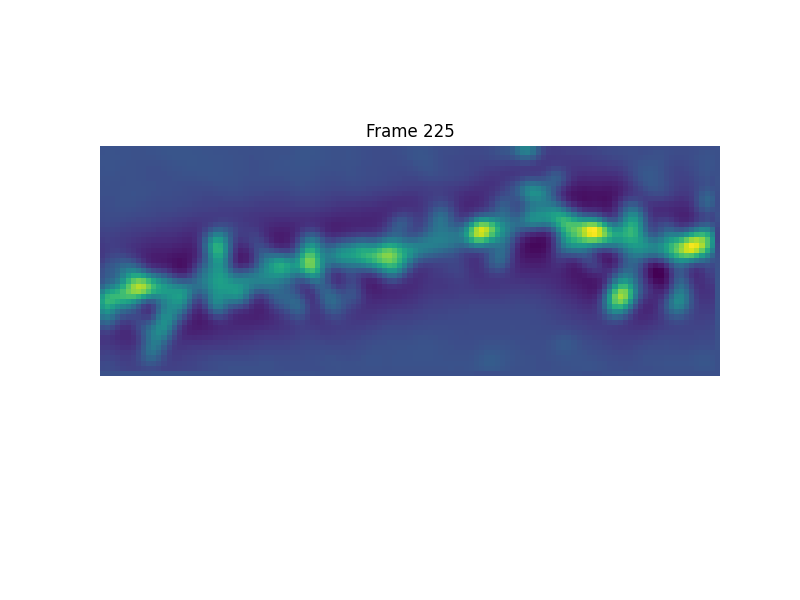

In [34]:
plt.imshow(yhat[:,:,0])
plt.show()

In [ ]:
play_movie(yhat, fr=30)

In [33]:
test = IMf
baseline_window = 435

from scipy.signal import medfilt

# # Apply the moving median filter along the third dimension
smoothed_data = medfilt(test, kernel_size=(1, 1, baseline_window))

# If you need to handle NaN values, you can use np.nanmedian within a custom function
# def moving_median_with_nan(data, window_size):
    # smoothed = np.empty_like(data)
    # for i in range(data.shape[0]):
    #     for j in range(data.shape[1]):
    #         smoothed[i, j, :] = medfilt(data[i, j, :], kernel_size=window_size)
    # return smoothed

# Apply the custom function
# smoothed_data = moving_median_with_nan(test, baselineWindow)


In [38]:
smoothed_test[:,:,0]

array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  1749.322971  ,  1769.55159699, ...,
          632.89071034,     0.        ,     0.        ],
       [    0.        ,  2133.79300746,  2123.05696556, ...,
         2012.26326707,     0.        ,     0.        ],
       ...,
       [    0.        , -5017.45282917, -6358.03359599, ...,
         4468.31231973,     0.        ,     0.        ],
       [    0.        , -3776.42369403, -5009.54177011, ...,
         3670.86507175,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [60]:
import numpy as np
import cv2
import scipy

def matlab_gaussian_filter(image, sigma):
    return scipy.ndimage.gaussian_filter(
        image.astype(float),
        sigma=sigma,
        radius=np.ceil(2 * sigma).astype(int),
    )

sigma = 1.3300

filter_size = int(2 * np.ceil(10 * sigma)) + 1

# Create a 2D array with zeros
DoGfilt = np.zeros((filter_size, filter_size))

# Set the center element to 1
DoGfilt[int(np.ceil(filter_size / 2)-1), int(np.ceil(filter_size / 2)-1)] = 1

k1 = int(2 * np.ceil(2*sigma)+1)
k2 = int(2 * np.ceil(10*sigma)+1)

# Apply Gaussian filters
DoGfilt1 = cv2.GaussianBlur(DoGfilt, (k1, k1), sigma, None, sigma, borderType = cv2.BORDER_CONSTANT)
DoGfilt2 = cv2.GaussianBlur(DoGfilt, (k2, k2), 5.0 * sigma, None, 5.0 * sigma, borderType = cv2.BORDER_CONSTANT)

# Subtract the two filtered images
DoGfilt = DoGfilt1 - DoGfilt2

# Subtract the mean value
DoGfilt = DoGfilt - np.mean(DoGfilt)

7 29


In [62]:
np.allclose(DoGfilt, DoGfilt_mat)

True

In [41]:
np.allclose(DoGfilt, DoGfilt_mat)

False

In [4]:
np.mean(DoGfilt, dtype=np.float64)  # Get the maximum values of each column

-3.30030625631735e-20

In [38]:
from scipy.io import loadmat

DoGfilt_mat = loadmat('/root/capsule/scratch/DoGfilt.mat')['DoGfilt']

In [42]:
DoG1_mat = loadmat('/root/capsule/scratch/dogmat.mat')['dog1']
DoG2_mat = loadmat('/root/capsule/scratch/dogmat.mat')['dog2']


In [58]:
np.allclose(DoG2_mat, DoGfilt2)

True

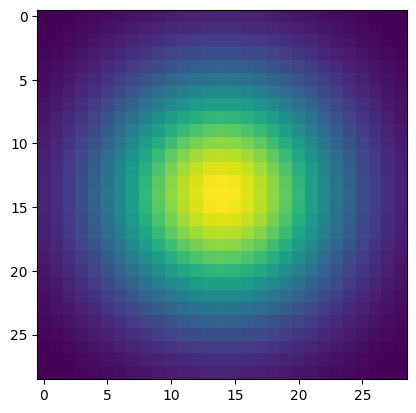

In [56]:
import matplotlib.pyplot as plt

plt.imshow(DoGfilt2)
plt.show()

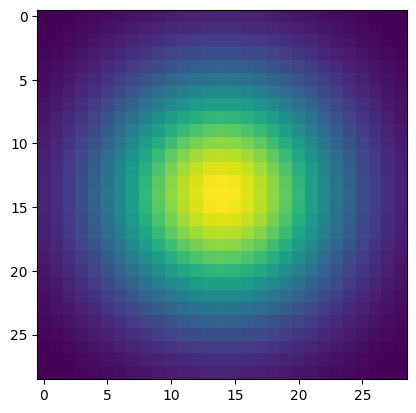

In [57]:
import matplotlib.pyplot as plt

plt.imshow(DoG2_mat)
plt.show()